# Chemometrics
<br>
**Julien Wist / 2017 / Universidad del Valle**
<br>
**Andrés Bernal / 2017 / ???**

An up-to-date version of this notebook can be found here: https://github.com/jwist/chemometrics/

To best understand the following notebook, please read chapter 2 of Brereton, R. G. (2003). Chemometrics. Technometrics. Chichester, UK: John Wiley & Sons, Ltd. http://doi.org/10.1002/0470863242.

Use the following commands to create the dataset of Table 2.6 of Brereton.

In [17]:
rm(list=ls(all=TRUE)) # to clean the variable space

In [169]:
options(repr.plot.width=4, repr.plot.height=4) # change these setting to plot larger figures

In [184]:
# we create the matrix manually
d <- c(6,60,4,34.841,6,60,2,16.567,6,20,4,45.396,6,20,2,27.939,4,60,4,19.825,4,60,2,1.444,4,20,4,37.673,4,20,2,23.131,6,40,3,23.088,4,40,3,12.325,5,60,3,16.461,5,20,3,33.489,5,40,4,26.189,5,40,2,8.337,5,40,3,19.192,5,40,3,16.579,5,40,3,17.794,5,40,3,16.65,5,40,3,16.799,5,40,3,16.635)
dim(d) <- c(4,20) # we force the data into a mtrix of dimension 4 x 20
# we create the data frame
datas <- data.frame("ph"=d[1,],"temp"=d[2,],"conc"=d[3,], "ph2"=d[1,]^2, "temp2"=d[2,]^2, "conc2"=d[3,]^2, "phTemp"=d[1,]*d[2,], "phConc"=d[1,]*d[3,], "tempConc"=d[2,]*d[3,], "yield"=d[4,])
datas

,ph,temp,conc,ph2,temp2,conc2,phTemp,phConc,tempConc,yield
1,6.000,60.000,4.000,36.000,3600.000,16.000,360.000,24.000,240.000,34.841
2,6.000,60.000,2.000,36.000,3600.000,4.000,360.000,12.000,120.000,16.567
3,6.000,20.000,4.000,36.000,400.000,16.000,120.000,24.000,80.000,45.396
4,6.000,20.000,2.000,36.000,400.000,4.000,120.000,12.000,40.000,27.939
5,4.000,60.000,4.000,16.000,3600.000,16.000,240.000,16.000,240.000,19.825
6,4.000,60.000,2.000,16.000,3600.000,4.000,240.000,8.000,120.000,1.444
7,4.000,20.000,4.000,16.000,400.000,16.000,80.000,16.000,80.000,37.673
8,4.000,20.000,2.000,16.000,400.000,4.000,80.000,8.000,40.000,23.131
9,6.000,40.000,3.000,36.000,1600.000,9.000,240.000,18.000,120.000,23.088
10,4.000,40.000,3.000,16.000,1600.000,9.000,160.000,12.000,120.000,12.325


we can perform a manual regression using the following sequence. 

In [119]:
# we define the matrix of data (X)
M <- cbind("intercept"=rep(1,20),datas[,1:9]) # adds intercept
M <- as.matrix(M)

# we define y, the response
y <- datas[,10]

# we calculate the regression coefficient manually
coeffs = data.frame("coeffs"=solve(t(M) %*% M) %*% t(M) %*% y)
round(coeffs, 3)

,coeffs
intercept,58.808
ph,-6.091
temp,-2.603
conc,4.805
ph2,0.598
temp2,0.02
conc2,0.154
phTemp,0.11
phConc,0.351
tempConc,0.029


where the first coefficient would be the intercept, as we already discussed in the previous example. 

We can check the data and the prediction.

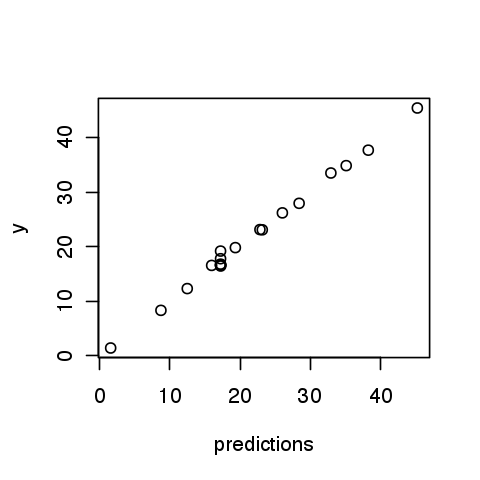

In [120]:
# we can check that predictions are just projection of our data on the coefficients
predictions <- M %*% as.matrix(coeffs)

plot(predictions,y)

By looking at the coefficient it looks like pH is the most important factor, but concentration and temperature are also significant. The other cross terms are, to the contrary, very small and seems not to influence the yield.

The problem with this analysis is that the coefficient are obtained by solving the linear model $y=D*c$. where $D$ is the experimental design matrix and $c$ is for the coefficients. Therefore if the values in the D matrix are large, as for the temperature, the corresponding coefficient will be small to maintain the product constant. It is not possible to compare directly the coefficient if the parameters are not scaled.

Before scaling the matrix $D$, here described as M, we can try to use statistics to help find out if what are the relevant parameters and how good is our model.

In [121]:
# we start the evaluation of our model
Rep <- duplicated(datas[,1:3])
R <- sum( Rep ) 
N <- dim(datas)[1]
P <- length(coeffs[[1]])
D <- N - P - R
D
N
P
R

[1] 5

[1] 20

[1] 10

[1] 5

There are 5 degrees of freedom, so the experimental design should allow to rule out or not the accuracy of the model.

In [153]:
S_replicate <- sum( (mean(datas$yield[Rep]) - datas$yield[Rep])^2 ) # R degrees of freedom
S_residual <- sum ( (predictions - y)^2 ) # N-P degrees of freedom (# or S_total - S_predicted)
S_total <- sum( datas$yield^2 ) # N degrees of freedom
S_predicted <- sum( predictions^2 ) 
S_lackOfFit <- S_residual - S_replicate # N-P-R degrees of freedom
Rsquare <- S_predicted / S_total

meanS_replicate <- S_replicate / R
meanS_residual <- S_residual / (N-P)
meanS_total <- S_total / N
meanS_predicted <- S_predicted / P
meanS_lackOfFit <- S_lackOfFit / D

result <- data.frame("mean replicate"=meanS_replicate,"mean residuals"=meanS_residual,"mean total"=meanS_total, "mean predicted"=meanS_predicted, "mean lack of fit"=meanS_lackOfFit)
round(result,2)

,mean.replicate,mean.residuals,mean.total,mean.predicted,mean.lack.of.fit
1,0.21,0.80,565.40,1130.00,1.39


In [154]:
# we calculate t-values and their probability associated 
T <- as.matrix(coeffs) / sqrt( diag( solve(t(M) %*% M) ) * meanS_residual )
result <- data.frame("T"=T)
result["t"] <- 2*pt(abs(T), df = N-P, lower.tail = FALSE)
result["1-t"] <- 1-(2 * pt(abs(T), df = N-P, lower.tail = FALSE))
round(result, 3)

,coeffs,t,1-t
intercept,4.544,0.001,0.999
ph,-1.104,0.295,0.705
temp,-18.27,0.00,1.00
conc,1.311,0.219,0.781
ph2,1.109,0.293,0.707
temp2,14.597,0.000,1.000
conc2,0.287,0.780,0.220
phTemp,6.966,0.000,1.000
phConc,1.111,0.293,0.707
tempConc,1.842,0.095,0.905


In [164]:
result <- data.frame( "F"=meanS_lackOfFit/meanS_replicate )
result["qf"] <- qf(0.95,D,R) # F-factor for 95% confidence
result["pf"] <- pf(result$F,D,R,lower.tail = TRUE)
round(result,2)

,F,qf,pf
1,6.64,5.05,0.97


Because p-value is larger than 0.05 we can conclude that the model is accurate. Or more precisely, we cannot rule out our model as inaccurate.

## relation between the importance of variables and their magnitude
We can scale the data. Sometime this is referred to as encoding the data.

In [191]:
maxs <- apply(d[1:3,],1,max); mins <- apply(d[1:3,],1,min)
d[1:3,] <- t( scale(t(d)[,1:3],center = (mins + maxs)/2, scale = (maxs - mins)/2) )
datas <- data.frame("ph"=d[1,],"temp"=d[2,],"conc"=d[3,], "ph2"=d[1,]^2, "temp2"=d[2,]^2, "conc2"=d[3,]^2, "phTemp"=d[1,]*d[2,], "phConc"=d[1,]*d[3,], "tempConc"=d[2,]*d[3,], "yield"=d[4,])
datas

,ph,temp,conc,ph2,temp2,conc2,phTemp,phConc,tempConc,yield
1,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,34.841
2,1.000,1.000,-1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,16.567
3,1.000,-1.000,1.000,1.000,1.000,1.000,-1.000,1.000,-1.000,45.396
4,1.000,-1.000,-1.000,1.000,1.000,1.000,-1.000,-1.000,1.000,27.939
5,-1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,1.000,19.825
6,-1.000,1.000,-1.000,1.000,1.000,1.000,-1.000,1.000,-1.000,1.444
7,-1.000,-1.000,1.000,1.000,1.000,1.000,1.000,-1.000,-1.000,37.673
8,-1.000,-1.000,-1.000,1.000,1.000,1.000,1.000,1.000,1.000,23.131
9,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,23.088
10,-1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,12.325


If we perform the regression again, the magnitude of the coefficient will not depend any more on their absolute value. This simplifies the analysis of finding the most important parameters.

In [27]:
# we define the matrix of data (X)
M <- as.matrix(datas[,1:9])
M <- cbind(rep(1,20),M) # adds intercept
# we define y, the response
y <- datas[,10]
# we calculate the regression coefficient manually
coeffs <- solve(t(M) %*% M) %*% t(M) %*% y
# we can check that predictions are just projection of our data on the coefficients
predictions <- M %*% coeffs

# we start the evaluation of our model
Rep <- duplicated(datas[,1:3])
R <- sum( Rep ) 
N <- dim(datas)[1]
P <- length(coeffs)
D <- N - P - R

S_replicate <- sum( (mean(datas$yield[Rep]) - datas$yield[Rep])^2 ) # R degrees of freedom
S_residual <- sum ( (predictions - y)^2 ) # N-P degrees of freedom (# or S_total - S_predicted)
S_total <- sum( datas$yield^2 ) # N degrees of freedom
S_predicted <- sum( predictions^2 ) 
S_lackOfFit <- S_residual - S_replicate # N-P-R degrees of freedom
Rsquare <- S_predicted / S_total

meanS_replicate <- S_replicate / R
meanS_residual <- S_residual / (N-P)
meanS_total <- S_total / N
meanS_predicted <- S_predicted / P
meanS_lackOfFit <- S_lackOfFit / D

F <- meanS_lackOfFit / meanS_replicate

result = data.frame("F"=F,"mean replicate"=meanS_replicate,"mean residuals"=meanS_residual,"mean total"=meanS_total, "mean predicted"=meanS_predicted, "mean lack of fit"=meanS_lackOfFit)
round(result,2)

# we calculate t-values and their probability associated 
ttest <- coeffs / sqrt( diag( solve(t(M) %*% M) ) * meanS_residual )
tprob <- 1-(2 * pt(abs(ttest), df = N-P, lower.tail = FALSE))
table2.11 <- data.frame("coeffs"=coeffs,"t"=ttest,"t-prob"=tprob*100)
table2.11

,F,mean.replicate,mean.residuals,mean.total,mean.predicted,mean.lack.of.fit
1,6.64,0.21,0.80,565.40,1130.00,1.39


,coeffs,t,t.prob
,17.20834,56.01061,100.00000
ph,5.34330,18.90673,100.00000
temp,-7.84900,-27.77289,100.00000
conc,8.65060,30.60927,100.00000
ph2,0.5979091,1.1094514,70.6797496
temp2,7.866409,14.596530,99.999995
conc2,0.1544091,0.2865141,21.9667327
phTemp,2.201000,6.965813,99.996128
phConc,0.351000,1.110859,70.737550
tempConc,0.582000,1.841937,90.470412


Scaling the data allows us to directly compare the coefficients, since the significance of the variable is a product of its magnitude by the coefficients. Now, all variable weight the same (their norm is equal to 1), so their coefficient directly reflects their importance. By comparing results obtained with and without scaling the variables we inmediatly notice important changes. By not scaling the data you might have wrongly concluded that only the first 3 parameters were relevant, while a proper scaling of the data shows that the $T^2$ and pH$ \times T$ might be relevant as well.

### Leverage

Finally we can test different experimental designs (See Table 2.15) and see how the prediction confidence depends on it. For example the accuracy of the prediction may change if points for sampling are distributed in a different manner.

<mark>Not only the number of point, and the number of replicate have an influence of the model accuracy, the way sample points are chosen also affect the result.</mark>

Here we calculate the leverate for designs of Table 2.15

In [168]:
A <- cbind(rep(1,11), c(1, 1, 1, 2, 2, 3, 4, 4, 5, 5, 5) )
round(diag( A %*% solve(t(A) %*% A) %*% t(A) ),2)

A <- cbind(rep(1,11), c(1, 1, 2, 2, 3, 3, 3, 4, 4, 5, 5) )
round(diag( A %*% solve(t(A) %*% A) %*% t(A) ),2)

A <- cbind(rep(1,11), c(1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 5) )
round(diag( A %*% solve(t(A) %*% A) %*% t(A) ),2)

[1] 0.23 0.23 0.23 0.13 0.13 0.09 0.13 0.13 0.23 0.23 0.23

[1] 0.29 0.29 0.14 0.14 0.09 0.09 0.09 0.14 0.14 0.29 0.29

[1] 0.18 0.18 0.18 0.18 0.10 0.10 0.10 0.12 0.12 0.26 0.50

For more on experimental design, please consult Brereton, R. G. (2003). Chemometrics. Technometrics. Chichester, UK: John Wiley & Sons, Ltd. http://doi.org/10.1002/0470863242